# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain_name)
print(brain)

BananaBrain
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
#TODO: PRINT REWARD POSSIBILITIES
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

### 4a. Model Definition

Since input is 1d, we can use simple FC Network

In [6]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNet(nn.Module):
    
    def __init__(self, state_size, action_size, seed):
        super(QNet, self).__init__()
        self.seed = torch.manual_seed(seed)
        fc_units = [64, 64]
        # TODO: Can automate generation of mid layers         
        self.fc1 = nn.Linear(state_size, fc_units[0])
        self.fc2 = nn.Linear(fc_units[0], fc_units[1])
        self.output = nn.Linear(fc_units[1], action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.output(x)
        

### 4b. Replay Buffer
Replay Buffer is a FIFO Data Structure (fixed-size buffer) to store experience tuples which would be later on sampled by DQNAgent to be used for learning.

Parameters we care about in replay buffer:
- buffer_size (int): maximum size of buffer
- batch_size (int): size of each training batch
- seed (int): random seed


In [7]:
import random
from collections import deque, namedtuple

Experience = namedtuple("experience",field_names=["state","action","reward","next_state","done"])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.seed = random.seed(seed)
        self.batch_size_ = batch_size
        self.memory_ = deque(maxlen=buffer_size)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        self.memory_.append(Experience(state, action, reward, next_state, done))
        
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory_, k=self.batch_size_)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
        # NonBlocking flag turned on for async GPU transfer, for speed gain.
        if torch.cuda.is_available():
            states = states.cuda(device, non_blocking = True)
            actions = actions.cuda(device, non_blocking = True)
            rewards = rewards.cuda(device, non_blocking = True)
            next_states = next_states.cuda(device, non_blocking = True)
            dones = dones.cuda(device, non_blocking = True)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory_)

### 4c. DQN Agent

DQN Agent

In [12]:
import torch.optim as optim
import copy 

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.995           # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

class DQNAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        # Initialize Member variable
        random.seed(seed)
        self.state_size_ = state_size
        self.action_size_ = action_size
        self.t_step_ = 0

        # Initialize Q-Networks
        # With Fixed Q-Target, we need two networks: local, target
        self.qnetwork_local_ = QNet(state_size, action_size, seed).to(device)
        self.qnetwork_target_ = QNet(state_size, action_size, seed).to(device)
        self.optimizer_ = optim.Adam(self.qnetwork_local_.parameters(), lr=LR)


        #ReplayBuffer
        self.replay_buffer_ = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
    
    def step(self, state, action, reward, next_state, done):
        """ Update replay_buffer and internal states of DQNAgent 
            with the most recent result from interaction of agent and environment.
        
        Params
        ======
            state (array_like): current state
            action (int): action taken
            reward (int): Reward recevied from taking action in current state
            next_state (int): next state after taking action in current state
            done (bool): Whether episode is terminated after taking the action in current state
        """
        self.replay_buffer_.add(state,action,reward,next_state,done)
        self.t_step_ = (self.t_step_ + 1) % UPDATE_EVERY
                
        if self.t_step_ == 0:
            # Make sure we have enough data inside the replay buffer for the batch size             
            if len(self.replay_buffer_) > BATCH_SIZE:
                experiences = self.replay_buffer_.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        Using epsilon-greedy
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        if random.random() > eps:
            state = torch.from_numpy(state).unsqueeze(0).float().to(device)
            self.qnetwork_local_.eval()
            with torch.no_grad():
                action = np.int64(torch.argmax(self.qnetwork_local_(state)).cpu().detach().numpy())
                self.qnetwork_local_.train()
        else:
            action = np.random.choice(np.arange(self.action_size_))
        return action

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        # Current estimate from qnetwork_local 
        current_estimate = torch.gather(self.qnetwork_local_(states), dim=1, index=actions)
        
        # Target estimate from qnetwork_target (using fixed q target mod)
        # [0] since output of torch max = [max_vals, indices]
        # Dont add discounted value if terminal
        with torch.no_grad():
            q_next_estimate = torch.max(self.qnetwork_target_(next_states),dim=1)[0].unsqueeze(1)
            target_estimate = rewards + (1-dones) * gamma * q_next_estimate

        #Compute Loss
        loss = F.mse_loss(current_estimate, target_estimate)
        
        self.optimizer_.zero_grad()
        loss.backward()
        self.optimizer_.step()
        
        # Update fixed_q_target
        self.soft_update(TAU)
        
        

    def soft_update(self, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(self.qnetwork_target_.parameters(), self.qnetwork_local_.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## 4d. DQNAgent - Environment Interaction Training Loop

In [13]:
import matplotlib.pyplot as plt
# Runtime/training loop Settings
n_episodes = 2000
max_tstep = 1000
eps_start=1.0
eps_end=0.01
eps_decay=0.995

# Initialize Runtime/training loop Variables
scores = []                                        # list containing scores from each episode
scores_window = deque(maxlen=100)                  # last 100 scores
seed = 0                                           # initialize random seed
agent = DQNAgent(state_size, action_size, seed)    # initialize Agent
eps = eps_start  # initialize epsilon

# Iterate over each episode
for i_episode in range(1, n_episodes+1):
    # Reset environment, set initial state and reward score every episode
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    score = 0

    # Iterate over each timestep
    for t in range(max_tstep):
        # Perform an action in the environment
        action = agent.act(state, eps)                 # send the action to the environment
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished

        # Update for next time step
        agent.step(state, action, reward, next_state, done) # Update Agent Internals
        state = next_state  # roll over the state to next time ste
        score += reward     # update the score

        # Break loop if episode completed
        if done:
            break 

    # Save most recent score
    scores_window.append(score)
    scores.append(score)

    eps = max(eps_end, eps_decay*eps) # Adjust epsilon

    print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")
    if i_episode % 100 == 0:
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
    if np.mean(scores_window) >= 13.0:
        print(f'\nEnvironment solved in {i_episode-100:d} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
        torch.save(agent.qnetwork_local_.state_dict(), 'checkpoint.pth')
        break


print("Final Average Score:",np.mean(scores_window))

Episode 100	Average Score: 1.26
Episode 200	Average Score: 4.11
Episode 300	Average Score: 8.20
Episode 400	Average Score: 9.25
Episode 500	Average Score: 12.12
Episode 558	Average Score: 13.01
Environment solved in 458 episodes!	Average Score: 13.01
Final Average Score: 13.01


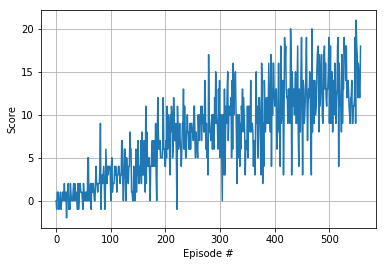

In [14]:
import matplotlib.pyplot as plt

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.grid(True)
plt.show()

When finished, you can close the environment.

In [ ]:
env.close()